In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
#matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
#tf.random.set_seed(22)

2.10.0


In [144]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [135]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0.0,3,22.0,1,0,2.110213,0,1,0,0,1
1,1.0,1,38.0,1,0,4.280593,1,0,1,0,0
2,1.0,3,26.0,0,0,2.188856,1,0,0,0,1
3,1.0,1,35.0,1,0,3.990834,1,0,0,0,1
4,0.0,3,35.0,0,0,2.202765,0,1,0,0,1


In [136]:
test.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,NaN,3,34.5,0,0,2.178064,0,1,0,1,0
1,NaN,3,47.0,1,0,2.079442,1,0,0,0,1
2,NaN,2,62.0,0,0,2.369075,0,1,0,1,0
3,NaN,3,27.0,0,0,2.268252,0,1,0,0,1
4,NaN,3,22.0,1,1,2.586824,1,0,0,0,1


In [145]:
x_train, y_train = train.drop(['Survived'], axis=1), train['Survived']
x_test = test.drop(['Survived'], axis=1)

In [146]:
x_train.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,3,22.0,1,0,2.110213,0,1,0,0,1
1,1,38.0,1,0,4.280593,1,0,1,0,0
2,3,26.0,0,0,2.188856,1,0,0,0,1
3,1,35.0,1,0,3.990834,1,0,0,0,1
4,3,35.0,0,0,2.202765,0,1,0,0,1


In [148]:
#y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

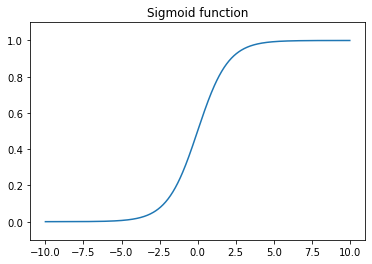

In [149]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

In [150]:
class Normalize(tf.Module):
    def __init__(self, x):
        # Initialize the mean and standard deviation for normalization
        self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
        self.std = tf.Variable(tf.math.reduce_std(x, axis=0))
    def norm(self, x):
        # Normalize the input
        return (x - self.mean)/self.std
    def unnorm(self, x):
        # Unnormalize the input
        return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

In [152]:
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [153]:
def log_loss(y_pred, y):
    # Compute the log loss function
    ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(ce)

In [154]:
class LogisticRegression(tf.Module):
    def __init__(self):
        self.built = False

    def __call__(self, x, train=True):
        # Initialize the model parameters on the first call
        if not self.built:
            # Randomly generate the weights and the bias term
            rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
            rand_b = tf.random.uniform(shape=[], seed=22)
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True
        # Compute the model output
        z = tf.add(tf.matmul(x, self.w), self.b)
        z = tf.squeeze(z, axis=1)
        if train:
            return z
        return tf.sigmoid(z)

In [155]:
def predict_class(y_pred, thresh=0.5):
    # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
    return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
    # Return the proportion of matches between `y_pred` and `y`
    y_pred = tf.math.sigmoid(y_pred)
    y_pred_class = predict_class(y_pred)
    check_equal = tf.cast(y_pred_class == y,tf.float32)
    acc_val = tf.reduce_mean(check_equal)
    return acc_val

In [156]:
print(x_train[:4])

tf.Tensor(
[[ 3.        22.         1.         0.         2.1102133  0.
   1.         0.         0.         1.       ]
 [ 1.        38.         1.         0.         4.280593   1.
   0.         1.         0.         0.       ]
 [ 3.        26.         0.         0.         2.1888564  1.
   0.         0.         0.         1.       ]
 [ 1.        35.         1.         0.         3.9908342  1.
   0.         0.         0.         1.       ]], shape=(4, 10), dtype=float32)


In [157]:
#x_train, y_train = train.drop(['Survived'], axis=1), train['Survived']
#x_test = test.drop(['Survived'], axis=1)
log_reg = LogisticRegression()

In [158]:
# Set training parameters
epochs = 500
learning_rate = 0.01
train_losses= []
#train_losses, test_losses = [], []
train_accs = []
#train_accs, test_accs = [], []
count = 0
# Set up the training loop and begin training
for epoch in range(epochs):
    
    batch_losses_train, batch_accs_train = [], []
    batch_losses_test, batch_accs_test = [], []
    #batch_losses_test, batch_accs_test = [], []
    # Iterate over the training data
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = log_reg(x_batch)
            batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        # Update the parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, log_reg.variables)
        for g,v in zip(grads, log_reg.variables):
            v.assign_sub(learning_rate * g)
        # Keep track of batch-level training performance
        batch_losses_train.append(batch_loss)
        batch_accs_train.append(batch_acc)
        
    # Iterate over the testing data
    #for x_batch, y_batch in test_dataset:
    #    y_pred_batch = log_reg(x_batch)
    #    batch_loss = log_loss(y_pred_batch, y_batch)
    #    batch_acc = accuracy(y_pred_batch, y_batch)
    #    # Keep track of batch-level testing performance
    #    batch_losses_test.append(batch_loss)
    #    batch_accs_test.append(batch_acc)
        
    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    #test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    #test_losses.append(test_loss)
    #test_accs.append(test_acc)
    if count % 50 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")
    if count == 499:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")
    count += 1

Epoch: 0, Training log loss: 0.770
Epoch: 50, Training log loss: 0.438
Epoch: 100, Training log loss: 0.438
Epoch: 150, Training log loss: 0.437
Epoch: 200, Training log loss: 0.438
Epoch: 250, Training log loss: 0.438
Epoch: 300, Training log loss: 0.437
Epoch: 350, Training log loss: 0.439
Epoch: 400, Training log loss: 0.438
Epoch: 450, Training log loss: 0.438
Epoch: 499, Training log loss: 0.438


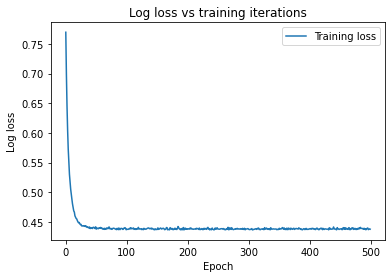

In [159]:
plt.plot(range(epochs), train_losses, label = "Training loss")
#plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

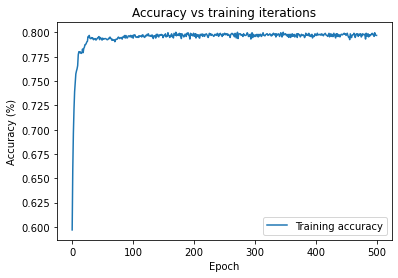

In [160]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
#plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [161]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
#print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.438


In [162]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
#print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.797


In [163]:
class ExportModule(tf.Module):
    def __init__(self, model, norm_x, class_pred):
        # Initialize pre- and post-processing functions
        self.model = model
        self.norm_x = norm_x
        self.class_pred = class_pred

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
    def __call__(self, x):
        # Run the `ExportModule` for new data points
        x = self.norm_x.norm(x)
        y = self.model(x, train=False)
        y = self.class_pred(y)
        return y

In [164]:
log_reg_export = ExportModule(model=log_reg,
                              norm_x=norm_x,
                              class_pred=predict_class)

In [165]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)

INFO:tensorflow:Assets written to: C:\Users\Alrziki\AppData\Local\Temp\tmpvpvtdf69\log_reg_export\assets


In [166]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test_norm)
len(test_preds.numpy())

418

In [167]:
test_data = pd.read_csv('test.csv')

In [168]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [169]:
test_data = test_data[["PassengerId"]]

In [170]:
test_data

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [171]:
prediction = pd.DataFrame(test_preds.numpy(),columns=['Survived'])

In [176]:
prediction = prediction['Survived'].astype(int)

In [177]:
prediction

0      1
1      1
2      1
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int32

In [178]:
submission =  pd.concat([test_data, prediction], axis=1,ignore_index=False)
#test_data.append(prediction, ignore_index=False)

In [179]:
submission

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [180]:
submission.to_csv('submission.csv', index=False)